## bureau record training

This notebook attempts to exploit the correlation between past bureau record and current defaulting rate. We have each training sample being one bureau record, and target being the corresponding current target --- bureau records belonging to the same customer will all use this customer's current target. We then use LightGBM classifier with auc loss to predict the probability of each bureau record belonging to a customer who has defaulted loan currently. When the model is trained, the prediction (a probability within (0,1)) is grouped by the current customer ID, and statistics such as mean/sum are computed. These statistics are saved to disk to be merged to the main training table.

In [17]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler

import lightgbm as lgb # Import the library
import gc

import matplotlib.pyplot as plt
import seaborn as sns

import os
print(os.listdir("../input"))
    
gc.enable()

['download_command.txt', 'application_test.csv', 'HomeCredit_columns_description.csv', 'POS_CASH_balance.csv', 'credit_card_balance.csv', 'installments_payments.csv', 'application_train.csv', 'bureau.csv', 'previous_application.csv', 'bureau_balance.csv', 'sample_submission.csv']


In [18]:
data = pd.read_csv('../input/application_train.csv', usecols=['SK_ID_CURR','TARGET'])

Create features for each bureau record. Apart from raw features from bureau table, we also compute:
* ratio between credit in debt and total credit
* ratio between credit limit and total credit
* ratio between credit overdue and total credit
* difference between actual and expected account close date

...

In [19]:
buro = pd.read_csv('../input/bureau.csv')

buro['DAYS_CREDIT_ENDDATE'].loc[buro['DAYS_CREDIT_ENDDATE'] < -40000] = np.nan
buro['DAYS_CREDIT_UPDATE'].loc[buro['DAYS_CREDIT_UPDATE'] < -40000] = np.nan
buro['DAYS_ENDDATE_FACT'].loc[buro['DAYS_ENDDATE_FACT'] < -40000] = np.nan

buro['AMT_DEBT_RATIO'] = buro['AMT_CREDIT_SUM_DEBT']/(1+buro['AMT_CREDIT_SUM'])
buro['AMT_LIMIT_RATIO'] = buro['AMT_CREDIT_SUM_LIMIT']/(1+buro['AMT_CREDIT_SUM'])
buro['AMT_SUM_OVERDUE_RATIO'] = buro['AMT_CREDIT_SUM_OVERDUE']/(1+buro['AMT_CREDIT_SUM'])
buro['AMT_MAX_OVERDUE_RATIO'] = buro['AMT_CREDIT_MAX_OVERDUE']/(1+buro['AMT_CREDIT_SUM'])
buro['DAYS_END_DIFF'] = buro['DAYS_ENDDATE_FACT'] - buro['DAYS_CREDIT_ENDDATE']

#Label Encoding
categorical_feats = [
    f for f in buro.columns if buro[f].dtype == 'object'
]

for f_ in categorical_feats:
    nunique = buro[f_].nunique(dropna=False)
    print(f_,nunique,buro[f_].unique())
    buro[f_], indexer = pd.factorize(buro[f_])
    
buro.head()

/var/folders/cm/wy6qs4m10756wz1k16wsjx000000gn/T/ipykernel_51849/3534816804.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  buro['DAYS_CREDIT_ENDDATE'].loc[buro['DAYS_CREDIT_ENDDATE'] < -40000] = np.nan
/var/folders/cm/wy6qs4m10756wz1k16wsjx000000gn/T/ipykernel_51849/3534816804.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  buro['DAYS_CREDIT_UPDATE'].loc[buro['DAYS_CREDIT_UPDATE'] < -40000] = np.nan
/var/folders/cm/wy6qs4m10756wz1k16wsjx000000gn/T/ipykernel_51849/3534816804.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

CREDIT_ACTIVE 4 ['Closed' 'Active' 'Sold' 'Bad debt']
CREDIT_CURRENCY 4 ['currency 1' 'currency 2' 'currency 4' 'currency 3']
CREDIT_TYPE 15 ['Consumer credit' 'Credit card' 'Mortgage' 'Car loan' 'Microloan'
 'Loan for working capital replenishment' 'Loan for business development'
 'Real estate loan' 'Unknown type of loan' 'Another type of loan'
 'Cash loan (non-earmarked)' 'Loan for the purchase of equipment'
 'Mobile operator loan' 'Interbank credit'
 'Loan for purchase of shares (margin lending)']


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,...,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,AMT_DEBT_RATIO,AMT_LIMIT_RATIO,AMT_SUM_OVERDUE_RATIO,AMT_MAX_OVERDUE_RATIO,DAYS_END_DIFF
0,215354,5714462,0,0,-497,0,-153.0,-153.0,NaN,0,...,NaN,0.0,0,-131.0,NaN,0.000000,NaN,0.0,NaN,0.0
1,215354,5714463,1,0,-208,0,1075.0,NaN,NaN,0,...,NaN,0.0,1,-20.0,NaN,0.761517,NaN,0.0,NaN,NaN
2,215354,5714464,1,0,-203,0,528.0,NaN,NaN,0,...,NaN,0.0,0,-16.0,NaN,NaN,NaN,0.0,NaN,NaN
3,215354,5714465,1,0,-203,0,NaN,NaN,NaN,0,...,NaN,0.0,1,-16.0,NaN,NaN,NaN,0.0,NaN,NaN
4,215354,5714466,1,0,-629,0,1197.0,NaN,77674.5,0,...,NaN,0.0,0,-21.0,NaN,NaN,NaN,0.0,0.028768,NaN


Aggragate the balance info for each buro record. Features include:
* month account closed relative to current application
* month with days past due (DPD) relative to current application
* mean/sum/max DPD of each bureau account

...

In [20]:
bubl = pd.read_csv('../input/bureau_balance.csv')
#what is the last month with DPD
bubl_last_DPD = bubl[bubl.STATUS.isin(['1','2','3','4','5'])].groupby(['SK_ID_BUREAU'])['MONTHS_BALANCE'].max()
bubl_last_DPD.rename('MONTH_LAST_DPD', inplace=True)
#print(bubl_last_DPD.head())

#what is the last month complete
bubl_last_C = bubl[bubl.STATUS=='C'].groupby(['SK_ID_BUREAU'])['MONTHS_BALANCE'].min()
bubl_last_C.rename('MONTH_LAST_C',inplace=True)
#print(bubl_last_C.head())

bubl['STATUS_DPD'] = bubl['STATUS']
bubl['STATUS_DPD'].loc[bubl['STATUS_DPD'].isin(['C','X'])]=np.nan
bubl['STATUS_DPD'] = bubl['STATUS_DPD'].astype('float')
bubl['YEAR_SCALE'] = (bubl['MONTHS_BALANCE']/12.0).apply(np.exp)
bubl['STATUS_DPD_SCALE'] = bubl['STATUS_DPD'] * bubl['YEAR_SCALE']
num_aggregations = {
    'STATUS_DPD': [ 'max', 'mean', 'sum'],
    'STATUS_DPD_SCALE': [ 'sum',],
    'YEAR_SCALE': [ 'sum']
}
balance = bubl.groupby('SK_ID_BUREAU').agg(num_aggregations)
balance.columns = pd.Index(['balance_' + e[0] + "_" + e[1].upper() for e in balance.columns.tolist()])
balance['balance_STATUS_DPD_SCALE_MEAN'] = balance['balance_STATUS_DPD_SCALE_SUM']/balance['balance_YEAR_SCALE_SUM']
del balance['balance_YEAR_SCALE_SUM']
gc.collect()
bubl_STATUS = pd.concat([bubl[['SK_ID_BUREAU','MONTHS_BALANCE']], pd.get_dummies(bubl['STATUS'], prefix='STATUS')], axis=1)
bubl_STATUS['STATUS_DPD'] = bubl_STATUS['STATUS_1'] + bubl_STATUS['STATUS_2'] + bubl_STATUS['STATUS_3'] + bubl_STATUS['STATUS_4'] + bubl_STATUS['STATUS_5'] 
num_aggregations = {
    'STATUS_C': [ 'sum'],
    'STATUS_X': [ 'sum'],
    'STATUS_0': [ 'sum'],
    'STATUS_DPD': ['sum']
}
balance_tot =  bubl_STATUS.groupby('SK_ID_BUREAU').agg(num_aggregations)
balance_12 =  bubl_STATUS.loc[bubl_STATUS['MONTHS_BALANCE']>=-12].groupby('SK_ID_BUREAU').agg(num_aggregations)
balance_tot.columns = pd.Index(['balance_tot_' + e[0] + "_" + e[1].upper() for e in balance_tot.columns.tolist()])
balance_12.columns = pd.Index(['balance_12_' + e[0] + "_" + e[1].upper() for e in balance_12.columns.tolist()])
balance_tot['balance_tot_STATUS_DPD_RATIO'] = balance_tot['balance_tot_STATUS_DPD_SUM']/(0.001 + balance_tot['balance_tot_STATUS_0_SUM'] + balance_tot['balance_tot_STATUS_DPD_SUM'])
balance_12['balance_12_STATUS_DPD_RATIO'] = balance_12['balance_12_STATUS_DPD_SUM']/(0.001 + balance_12['balance_12_STATUS_0_SUM'] + balance_12['balance_12_STATUS_DPD_SUM'])
balance = balance.merge(balance_tot, how='outer', on='SK_ID_BUREAU')             
balance = balance.merge(balance_12, how='outer', on='SK_ID_BUREAU')
balance['balance_has_DPD'] = (balance['balance_STATUS_DPD_MAX']>0).astype('int')

del balance_tot, balance_12, bubl_STATUS
gc.collect()
balance.head()

/var/folders/cm/wy6qs4m10756wz1k16wsjx000000gn/T/ipykernel_51849/32153147.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bubl['STATUS_DPD'].loc[bubl['STATUS_DPD'].isin(['C','X'])]=np.nan


,balance_STATUS_DPD_MAX,balance_STATUS_DPD_MEAN,balance_STATUS_DPD_SUM,balance_STATUS_DPD_SCALE_SUM,balance_STATUS_DPD_SCALE_MEAN,balance_tot_STATUS_C_SUM,balance_tot_STATUS_X_SUM,balance_tot_STATUS_0_SUM,balance_tot_STATUS_DPD_SUM,balance_tot_STATUS_DPD_RATIO,balance_12_STATUS_C_SUM,balance_12_STATUS_X_SUM,balance_12_STATUS_0_SUM,balance_12_STATUS_DPD_SUM,balance_12_STATUS_DPD_RATIO,balance_has_DPD
SK_ID_BUREAU,,,,,,,,,,,,,,,,
5001709,NaN,NaN,0.0,0.0,0.0,86,11,0,0,0.0,13.0,0.0,0.0,0.0,0.0,0
5001710,0.0,0.0,0.0,0.0,0.0,48,30,5,0,0.0,13.0,0.0,0.0,0.0,0.0,0
5001711,0.0,0.0,0.0,0.0,0.0,0,1,3,0,0.0,0.0,1.0,3.0,0.0,0.0,0
5001712,0.0,0.0,0.0,0.0,0.0,9,0,10,0,0.0,9.0,0.0,4.0,0.0,0.0,0
5001713,NaN,NaN,0.0,0.0,0.0,0,22,0,0,0.0,0.0,13.0,0.0,0.0,0.0,0


Merge bureau balance feature with main bureau table:

In [21]:
buro_meta = buro.merge(balance, on='SK_ID_BUREAU', how='left')
del buro, balance
gc.collect()
print("bureau data shape", buro_meta.shape)

bureau data shape (1716428, 38)


Broadcast current target to bureau record, according to the current ID each bureau record correspond to.

In [22]:
target_map = pd.Series(data.TARGET.values, index=data.SK_ID_CURR.values)
y = buro_meta['SK_ID_CURR'].map(target_map)

Split train and test set (test set are those without target)

In [23]:
train_x = buro_meta.loc[~y.isnull()]
test_x = buro_meta.loc[y.isnull()]
train_y = y.loc[~y.isnull()]

In [24]:
excluded_feats = ['SK_ID_CURR','SK_ID_BUREAU']
features = [f_ for f_ in train_x.columns.values if not f_ in excluded_feats]
print(excluded_feats)

train_x = buro_meta.loc[~y.isnull()]
test_x = buro_meta.loc[y.isnull()]
train_y = y.loc[~y.isnull()]

# Run a 5 fold
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=777)
oof_preds = np.zeros(train_x.shape[0])
sub_preds = np.zeros(test_x.shape[0])
feature_importance_df = pd.DataFrame()

['SK_ID_CURR', 'SK_ID_BUREAU']


Train LightGBM classifier

In [25]:



# Assume 'folds', 'train_x', 'train_y', 'test_x', 'features', 
# 'categorical_feats', and 'feature_importance_df' are pre-defined.

# --- BEST PRACTICE: Convert categorical features to 'category' dtype BEFORE the loop ---
# This is the modern way to handle categoricals, replacing the `categorical_feature` parameter.
for col in categorical_feats:
    train_x[col] = train_x[col].astype('category')
    test_x[col] = test_x[col].astype('category')

scores = []
oof_preds = np.zeros(train_x.shape[0])
sub_preds = np.zeros(test_x.shape[0])

for n_fold, (trn_idx, val_idx) in enumerate(folds.split(train_x, train_y)):
    trn_x_fold, val_x_fold = train_x[features].iloc[trn_idx], train_x[features].iloc[val_idx]
    trn_y_fold, val_y_fold = train_y.iloc[trn_idx], train_y.iloc[val_idx]
    
    # Note: Removed 'silent=True' as it's deprecated. 'verbose=-1' handles it.
    # Also removed 'metric' as it's better defined in .fit() via eval_metric.
    clf = lgb.LGBMClassifier(
        n_estimators=5000,
        learning_rate=0.05,
        num_leaves=20,
        colsample_bytree=0.8,
        subsample=0.9,
        max_depth=5,
        reg_alpha=5,
        reg_lambda=4,
        min_split_gain=0.002,
        min_child_weight=40,
        verbose=-1, # This correctly silences constructor output
        n_jobs=16,
        random_state=n_fold * 619,
        scale_pos_weight=2
    )
    
    # --- MODERN API: Use a list of callbacks for early stopping and logging ---
    callbacks = [
        lgb.early_stopping(stopping_rounds=60, verbose=True), # New way for early stopping
        lgb.log_evaluation(period=100) # New way for verbose logging
    ]
    
    # The `categorical_feature` parameter is no longer needed if dtypes are set
    clf.fit(trn_x_fold, trn_y_fold, 
            eval_set=[(val_x_fold, val_y_fold)], 
            eval_metric='auc',
            callbacks=callbacks # Pass the callbacks list here
           )
    
    oof_preds[val_idx] = clf.predict_proba(val_x_fold)[:, 1]
    sub_preds += clf.predict_proba(test_x[features])[:, 1] / folds.n_splits
    
    fold_score = roc_auc_score(val_y_fold, oof_preds[val_idx])
    scores.append(fold_score)
    print('Fold %2d AUC : %.6f' % (n_fold + 1, fold_score))
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    del clf, trn_x_fold, trn_y_fold, val_x_fold, val_y_fold
    gc.collect()
    
print('Full AUC score %.6f +- %0.4f' % (roc_auc_score(train_y, oof_preds), np.std(scores)))

/var/folders/cm/wy6qs4m10756wz1k16wsjx000000gn/T/ipykernel_51849/172379520.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_x[col] = train_x[col].astype('category')
/var/folders/cm/wy6qs4m10756wz1k16wsjx000000gn/T/ipykernel_51849/172379520.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_x[col] = test_x[col].astype('category')


Training until validation scores don't improve for 60 rounds
Early stopping, best iteration is:
[3]	valid_0's auc: 0.591829	valid_0's binary_logloss: 0.273102
Fold  1 AUC : 0.591829
Training until validation scores don't improve for 60 rounds
Early stopping, best iteration is:
[4]	valid_0's auc: 0.589845	valid_0's binary_logloss: 0.273063
Fold  2 AUC : 0.589845
Training until validation scores don't improve for 60 rounds
Early stopping, best iteration is:
[4]	valid_0's auc: 0.595888	valid_0's binary_logloss: 0.273011
Fold  3 AUC : 0.595888
Training until validation scores don't improve for 60 rounds
Early stopping, best iteration is:
[3]	valid_0's auc: 0.59036	valid_0's binary_logloss: 0.273077
Fold  4 AUC : 0.590360
Training until validation scores don't improve for 60 rounds
Early stopping, best iteration is:
[4]	valid_0's auc: 0.590976	valid_0's binary_logloss: 0.272963
Fold  5 AUC : 0.590976
Full AUC score 0.589975 +- 0.0022


Get prediction for each bureau record -- giving each bureau record a score, which meatures how likely it belongs to a user who has defaulting account currently.

In [30]:
train_buro_score = train_x[['SK_ID_CURR','SK_ID_BUREAU','DAYS_CREDIT']]
train_buro_score['score'] = oof_preds
test_buro_score = test_x[['SK_ID_CURR','SK_ID_BUREAU','DAYS_CREDIT']]
test_buro_score['score'] = sub_preds
buro_score = pd.concat([train_buro_score,test_buro_score])
buro_score.to_csv('../output/buro_score.csv',index=False,compression='zip')

/var/folders/cm/wy6qs4m10756wz1k16wsjx000000gn/T/ipykernel_51849/3513316464.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_buro_score['score'] = oof_preds
/var/folders/cm/wy6qs4m10756wz1k16wsjx000000gn/T/ipykernel_51849/3513316464.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_buro_score['score'] = sub_preds


Group by current ID, create aggragated bureau score. These will be the features we use for final training.

Aggragated features include: mean, max, sum, variance, sum of past two year.

Note we subtract the global mean of all predictions, this is to prevent the "sum" feature penalized users with more accounts. The max/mean/var features are not affected by the substraction.

In [27]:
buro_score['score'] -= buro_score['score'].mean()
agg_buro_score = buro_score.groupby('SK_ID_CURR')['score'].agg({'max','mean','sum','var'})

agg_buro_score_recent2y = buro_score.loc[buro_score['DAYS_CREDIT']>-365.25*2].groupby('SK_ID_CURR')['score'].sum()

idx = buro_score.groupby(['SK_ID_CURR'])['DAYS_CREDIT'].idxmax()
agg_buro_score_last = buro_score[['SK_ID_CURR','score']].loc[idx.values]
agg_buro_score_last.set_index('SK_ID_CURR',inplace=True)

agg_buro_score['recent2y_sum'] = agg_buro_score_recent2y
agg_buro_score['last'] = agg_buro_score_last
agg_buro_score = agg_buro_score.add_prefix('buro_score_')
agg_buro_score['TARGET'] = target_map
agg_buro_score.to_csv('../output/agg_buro_score.csv',compression='zip')
agg_buro_score.groupby('TARGET').mean()

,buro_score_sum,buro_score_max,buro_score_var,buro_score_mean,buro_score_recent2y_sum,buro_score_last
TARGET,,,,,,
0.0,-0.001260,0.007069,0.000040,0.000167,0.013636,0.004466
1.0,0.014127,0.012102,0.000069,0.003170,0.025253,0.008263


Check how the aggregated features are correlated to current target. Idealy we should see a significant correlation.

In [28]:
for col in agg_buro_score.columns:
    print(col,agg_buro_score[col].corr(agg_buro_score['TARGET']))

buro_score_sum 0.1522454814748642
buro_score_max 0.14266479412927213
buro_score_var 0.11644375623745844
buro_score_mean 0.15970474957088
buro_score_recent2y_sum 0.13561052220328235
buro_score_last 0.12179549395870211
TARGET 1.0


Plot feature importance

/Users/chenzeyu/opt/miniforge3/envs/tf26/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/chenzeyu/opt/miniforge3/envs/tf26/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/chenzeyu/opt/miniforge3/envs/tf26/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0.5, 1.0, 'Feature scores wrt split importances')

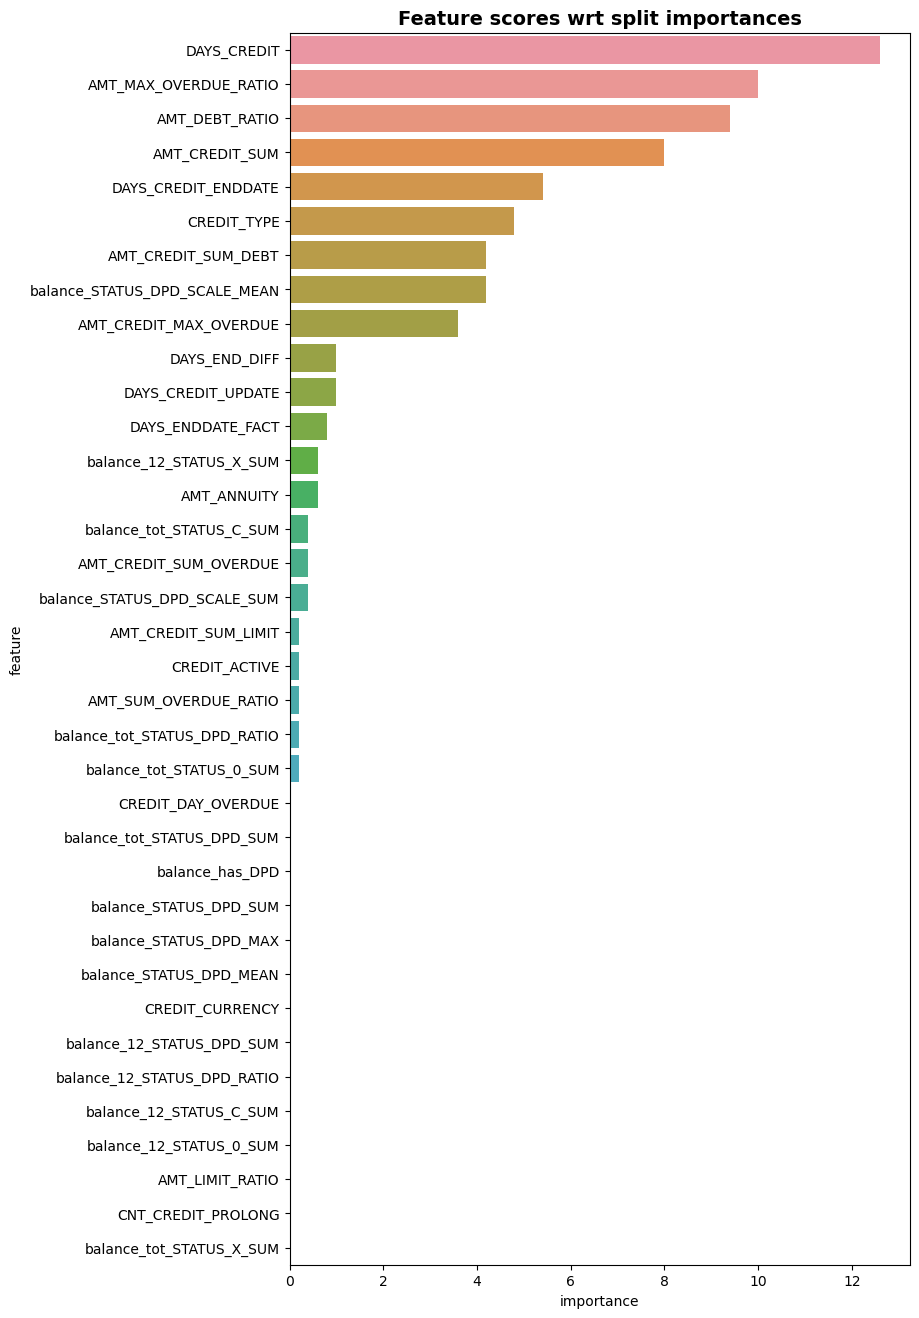

In [29]:
# Plot feature importances
feature_importance = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(
    by="importance", ascending=False)

best_features = feature_importance.iloc[:50].reset_index()

import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(8, 16))
gs = gridspec.GridSpec(1, 1)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='importance', y='feature', data=best_features, ax=ax)
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)